#step 1: import the packages

reference: beleznay and kunimoto 2022.
https://watermark.silverchair.com/stac2179.pdf?token=AQECAHi208BE49Ooan9kkhW_Ercy7Dm3ZL_9Cf3qfKAc485ysgAAA3cwggNzBgkqhkiG9w0BBwagggNkMIIDYAIBADCCA1kGCSqGSIb3DQEHATAeBglghkgBZQMEAS4wEQQMYyqk1AoUGPE-9vZ2AgEQgIIDKu5552AYlV37zh55o1_erXyASdtBoCoVqmN9t2MpBDfJcEoEf3P0Er30gxwvtg8yooVf217n5Fe_3ga7oxjo89vdh5VPN058z-RehjM7AFTskvjSxdqPfKxZ7UulYRI0TdCJFDdvtuSl2qp2RC5Y75NHt7snAGoT6vqcL4OjUmhw5QlsOBRDq_f-ONO0bzS4cCj328sRXiX4WaHT7N_SplaN6MtRsNhUQRT54sLZBFaz48KIv2D0QoRV_E-uo2Yz1NhNkZ6LjYSAsKsfsGGrxfd57CfLupSa-J0c3I6RKMnphMEH3HZva0lE8_6RxdlqW7BUHoaRxrtfvSwdebHuj2LJGsWQkxSYV_3FGzS8sVpzAySOADYB_VEU9IlRpd0mT9NYAbtwjtPESZE7o_qGqCtl5EQw6bfPAqDpEbg_tpK6bqWQSKkX61eV8fPMPPK1rbxd_vy5kj824NE4yh4VG6yPnqp6PB23bQHSCG80MhycB0hGPcnXpvad7JDV2wPILBWBAV4dH_ducmW9VZtSW34sNGtQguqMpu_BHKUOefFvV55YEht3tU1Wona5s37MHfQepljDEMomtZ4FAcM2NlP_jlUD0mGl5cOBacO_dD9FjvJtJQPAny4ROlLQxbAsUvS9j24Dr67P_BtX6JkoVbGxE617yzt_ILXVKGA1A1okIA5VFkKUJsnxNHyO6ugtaExW-xyNfmj62h1NzgrUoeM4mvMgYsrHXYLpY-UO7wvFUCBP_22_Pegg0BQq9LR30QThV-M_vyjHsDTjLJwMMSJS86an0q0tzTQY3pFNznPcnguQG0EQ0RMZAowmkQ3AR-gPCHwrgdlWM9S-FK35NI5hKP3snpN6nxwQzz8YW-LEY7YNR9U407qaPZUV_x_8jc3EjMzRfD9W9sbyR3TAcVuHkD7i1A8D0l5SuozJHtwbxbSjJVDIw58cR4MXntw5nao6fzv8EvTpRqOySofM6tasgnMJikU2gCDdnQyzCrnfz3V2pvscqA-_srMh_L6YR54VFRxdTKN2M-giL7V5NrvJ5Csu31FOCO0tkwmgzOhRVsTnZfd7GG6ioA

In [1]:
import jax

ModuleNotFoundError: No module named 'jax'

In [2]:
import pymultinest

ModuleNotFoundError: No module named 'pymultinest'

In [3]:
import ultranest

ModuleNotFoundError: No module named 'ultranest'

In [1]:
import dynesty

ModuleNotFoundError: No module named 'dynesty'

# First: find stars.

In [1]:
from astropy.io import fits
from astropy.table import Table

from astroquery.mast import Observations
from astroquery.mast import Tesscut

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from astroquery.mast import Catalogs
# Observations.enable_cloud_dataset()

import numpy as np
import astropy.units as u
from astropy.coordinates import SkyCoord
from astroquery.gaia import Gaia
import lightkurve

from tqdm import tqdm
from astroquery.exceptions import InvalidQueryError

# Important: ensure files are retrieved from AWS 
Observations.enable_cloud_dataset(provider='AWS')

INFO: Using the S3 STScI public dataset [astroquery.mast.cloud]


In [52]:
# note: below I'm testing how long it takes to download from the Ctl

In [53]:
# we want to make some cuts on the Tess Candidate Target List to find bright main-sequence stars. to-do: motivate the cuts.

In [2]:
%%time

catalog_data = Catalogs.query_criteria(catalog="Ctl",
                                       Tmag=[0, 10.5], 
                                      logg=[4.1,400],
                                      mass=[0.8, 1.05])

CPU times: user 8.33 s, sys: 1.07 s, total: 9.39 s
Wall time: 24.4 s


In [3]:
catalog_data

ID,version,HIP,TYC,UCAC,TWOMASS,SDSS,ALLWISE,GAIA,APASS,KIC,objType,typeSrc,ra,dec,POSflag,pmRA,e_pmRA,pmDEC,e_pmDEC,PMflag,plx,e_plx,PARflag,gallong,gallat,eclong,eclat,Bmag,e_Bmag,Vmag,e_Vmag,umag,e_umag,gmag,e_gmag,rmag,e_rmag,imag,e_imag,zmag,e_zmag,Jmag,e_Jmag,Hmag,e_Hmag,Kmag,e_Kmag,TWOMflag,prox,w1mag,e_w1mag,w2mag,e_w2mag,w3mag,e_w3mag,w4mag,e_w4mag,GAIAmag,e_GAIAmag,Tmag,e_Tmag,TESSflag,SPFlag,Teff,e_Teff,logg,e_logg,MH,e_MH,rad,e_rad,mass,e_mass,rho,e_rho,lumclass,lum,e_lum,d,e_d,ebv,e_ebv,numcont,contratio,disposition,duplicate_id,priority,eneg_EBV,epos_EBV,EBVflag,eneg_Mass,epos_Mass,eneg_Rad,epos_Rad,eneg_rho,epos_rho,eneg_logg,epos_logg,eneg_lum,epos_lum,eneg_dist,epos_dist,distflag,eneg_Teff,epos_Teff,TeffFlag,gaiabp,e_gaiabp,gaiarp,e_gaiarp,gaiaqflag,starchareFlag,VmagFlag,BmagFlag,splists,e_RA,e_Dec,RA_orig,Dec_orig,e_RA_orig,e_Dec_orig,raddflag,wdflag,objID
str10,str8,int64,str12,str10,str16,str19,str19,str19,str8,int64,str4,str7,float64,float64,str7,float64,float64,float64,float64,str5,float64,float64,str5,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str19,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str5,str5,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str5,float64,float64,float64,float64,float64,float64,int64,float64,str1,str9,float64,float64,float64,str9,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str6,float64,float64,str6,float64,float64,float64,float64,int64,str1,str8,str8,str15,float64,float64,float64,float64,float64,float64,int64,int64,str10
257486953,20190415,--,0004-01211-1,470-000036,00012257+0348137,1237678660350443525,J000122.66+034813.6,2740122790489701376,36101679,--,STAR,tmgaia2,0.344014992249018,3.80382001946707,tmgaia2,146.948,0.0785775,-2.18292,0.0365631,gaia2,8.86194,0.0507367,gaia2,99.6790809499965,-56.7907190407385,1.83033674668151,3.35274204776744,11.505,0.143,10.942,0.01,14.3561,0.00539245,11.5687,0.000667307,10.7394,0.000559878,10.5503,0.000599356,12.8011,0.0102534,9.525,0.026,9.107,0.024,9.042,0.021,AAA-222-111-000-0-0,nan,8.983,0.023,9.047,0.019,9.005,0.033,8.635,0.379,10.6881,0.00022,10.1918,0.006,rered,spect,5341.65,143.697,4.54113,0.0907658,-0.201,0.015,0.853239,0.0557889,0.923,0.117416,1.4859,0.389627,DWARF,0.5339956,0.01659735,112.48,0.647,0.0101352,0.0038456,27,0.03483629,--,--,0.0,0.00244247,0.00524873,panstarrs,0.10486,0.129972,0.0621553,0.0494226,0.31747,0.461784,0.0833452,0.0981863,0.0125266,0.0206681,0.643,0.651,bj2018,150.666,136.728,spect,11.0949,0.000455,10.1404,0.000426,1,--,tycho2v3,tycho2b3,planetcandidate,1.21935322296911,0.567092439365747,0.34464908190135,3.80381062101592,0.0422055151724629,0.0203261439774303,1,0,95867
388583226,20190415,--,4500-00124-1,849-000014,00004121+7940398,--,J000041.30+794039.9,564638150446547200,60652017,--,STAR,tmgaia2,0.171723066040282,79.6777485493965,tmgaia2,23.2049,0.0463689,0.752656,0.0441405,gaia2,6.3842,0.0331064,gaia2,120.572822336236,17.0392128647769,65.4255217247576,64.4779480185437,11.001,0.072,10.244,0.005,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,8.922,0.027,8.612,0.033,8.523,0.021,AAA-122-111-000-0-0,nan,8.454,0.022,8.48,0.02,8.395,0.022,8.311,0.211,10.0725,0.001459,9.6085,0.0083,rered,gaia2,5655.0,121.218,4.14638,0.0746591,nan,nan,1.39908,0.066985,1.0,0.125138,0.365152,0.0760686,DWARF,1.80347264,0.0588778,155.936,0.811,0.0217066,0.008248645,157,0.0207567867,--,--,0.0025412635165229,0.00913321,0.00736408,panstarrs,0.0875932,0.162682,0.079991,0.0539789,0.0629468,0.0891903,0.074668,0.0746503,0.0552031,0.0625525,0.807,0.815,bj2018,134.725,107.712,dered,10.4504,0.004713,9.56295,0.00391,1,--,tycho2v3,tycho2b3,planetcandidate,0.936393976453562,0.684649721171938,0.172280648286862,79.677751790477,0.0266482483131485,0.02541745671

In [4]:
# next, download a single star from this catalog to inspect the data type we're working with.

In [5]:
%%time
TESS_table = Observations.query_criteria(objectname='TIC ' + catalog_data['ID'][0]
                                         , obs_collection="TESS"
                                         , dataproduct_type='timeseries'
                                         ) 

data_products = Observations.get_product_list(TESS_table) 


CPU times: user 29.8 ms, sys: 1.95 ms, total: 31.8 ms
Wall time: 10.7 s


In [6]:
data_products

obsID,obs_collection,dataproduct_type,obs_id,description,type,dataURI,productType,productGroupDescription,productSubGroupDescription,productDocumentationURL,project,prvversion,proposal_id,productFilename,size,parent_obsid,dataRights,calib_level,filters
str8,str4,str10,str47,str18,str1,str73,str7,str28,str2,str1,str4,str20,str6,str55,int64,str8,str6,int64,str4
63404332,TESS,timeseries,tess2021232031932-s0042-0000000257486953-0213-s,Light curves,S,mast:TESS/product/tess2021232031932-s0042-0000000257486953-0213-s_lc.fits,SCIENCE,Minimum Recommended Products,LC,--,SPOC,spoc-5.0.43-20210918,N/A,tess2021232031932-s0042-0000000257486953-0213-s_lc.fits,1863360,63404332,PUBLIC,3,TESS
63404332,TESS,timeseries,tess2021232031932-s0042-0000000257486953-0213-s,Target pixel files,S,mast:TESS/product/tess2021232031932-s0042-0000000257486953-0213-s_tp.fits,SCIENCE,Minimum Recommended Products,TP,--,SPOC,spoc-5.0.43-20210918,N/A,tess2021232031932-s0042-0000000257486953-0213-s_tp.fits,44939520,63404332,PUBLIC,2,TESS
63404336,TESS,timeseries,tess2021232031932-s0042-0000000257488401-0213-s,Light curves,S,mast:TESS/product/tess2021232031932-s0042-0000000257488401-0213-s_lc.fits,SCIENCE,Minimum Recommended Products,LC,--,SPOC,spoc-5.0.43-20210918,G04191,tess2021232031932-s0042-0000000257488401-0213-s_lc.fits,1863360,63404336,PUBLIC,3,TESS
63404336,TESS,timeseries,tess2021232031932-s0042-0000000257488401-0213-s,Target pixel files,S,mast:TESS/product/tess2021232031932-s0042-0000000257488401-0213-s_tp.fits,SCIENCE,Minimum Recommended Products,TP,--,SPOC,spoc-5.0.43-20210918,G04191,tess2021232031932-s0042-0000000257488401-0213-s_tp.fits,44939520,63404336,PUBLIC,2,TESS


In [16]:
# Keep only the science products
filtered = Observations.filter_products(data_products, productType="SCIENCE")

# Be selective about the columns we display
cols = ['obs_id', 'description', 'productSubGroupDescription']

# Look at the first five rows of the filtered results
filtered[0:10][cols]
ex_id = filtered[filtered['productSubGroupDescription']=='LC']['obs_id'][0]
# ex_id = filtered['obs_id'][0]

lc_prod = Observations.filter_products(data_products
                                      , obs_id = ex_id
                                      , productSubGroupDescription = "LC"
                                      )
# Get the cloud URI
lc_uri = Observations.get_cloud_uris(lc_prod)[0]

# open the cloud fits file
lc_fits = fits.open(lc_uri, use_fsspec=True, fsspec_kwargs={"anon": True})

# take a peek at our fits file
lc_fits.info()

Filename: <class 's3fs.core.S3File'>
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      44   ()      
  1  LIGHTCURVE    1 BinTableHDU    167   18342R x 20C   [D, E, J, E, E, E, E, E, E, J, D, E, D, E, D, E, D, E, E, E]   
  2  APERTURE      1 ImageHDU        49   (11, 11)   int32   


In [10]:
lc = lc_fits[1].data
lc.columns

ColDefs(
    name = 'TIME'; format = 'D'; unit = 'BJD - 2457000, days'; disp = 'D14.7'
    name = 'TIMECORR'; format = 'E'; unit = 'd'; disp = 'E14.7'
    name = 'CADENCENO'; format = 'J'; disp = 'I10'
    name = 'SAP_FLUX'; format = 'E'; unit = 'e-/s'; disp = 'E14.7'
    name = 'SAP_FLUX_ERR'; format = 'E'; unit = 'e-/s'; disp = 'E14.7'
    name = 'SAP_BKG'; format = 'E'; unit = 'e-/s'; disp = 'E14.7'
    name = 'SAP_BKG_ERR'; format = 'E'; unit = 'e-/s'; disp = 'E14.7'
    name = 'PDCSAP_FLUX'; format = 'E'; unit = 'e-/s'; disp = 'E14.7'
    name = 'PDCSAP_FLUX_ERR'; format = 'E'; unit = 'e-/s'; disp = 'E14.7'
    name = 'QUALITY'; format = 'J'; disp = 'B16.16'
    name = 'PSF_CENTR1'; format = 'D'; unit = 'pixel'; disp = 'F10.5'
    name = 'PSF_CENTR1_ERR'; format = 'E'; unit = 'pixel'; disp = 'E14.7'
    name = 'PSF_CENTR2'; format = 'D'; unit = 'pixel'; disp = 'F10.5'
    name = 'PSF_CENTR2_ERR'; format = 'E'; unit = 'pixel'; disp = 'E14.7'
    name = 'MOM_CENTR1'; format = 'D'; u

Text(0.5, 0, 'TIME  (BJD-2457000)')

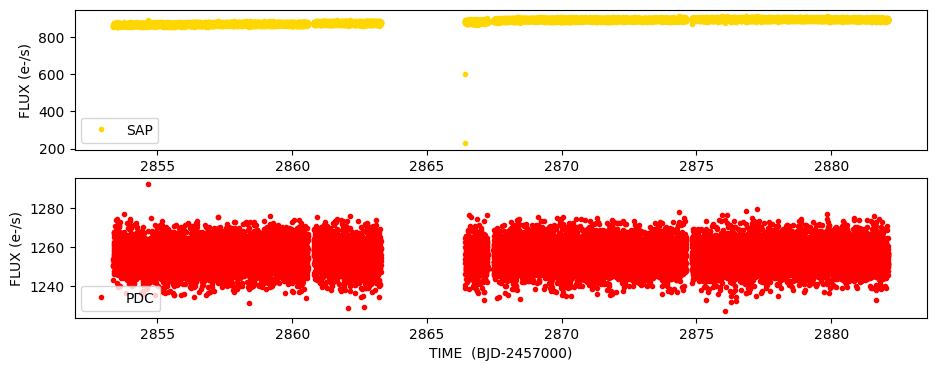

In [11]:
sapflux = lc['SAP_FLUX'] #SAP flux column
pdcflux = lc['PDCSAP_FLUX'] #PDCSAP flux column
time_lc = lc['TIME'] #time column

fig = plt.figure(figsize = (11,4))

fig.add_subplot(211)
plt.plot(time_lc, sapflux,'.', label = 'SAP', color = "gold")
plt.legend(loc = 'lower left')
plt.ylabel("FLUX (e-/s)")

fig.add_subplot(212)
plt.plot(time_lc, pdcflux,'.', label = 'PDC', color = "red")
plt.legend(loc = 'lower left')
plt.ylabel("FLUX (e-/s)")
plt.xlabel('TIME  (BJD-2457000)')

# Then: loop over and download all the files (clear TIKE angle)

In [12]:
# explain that we're writing a function here. and lay out what each step does. first, here's the slow version.

In [10]:
def download_data(catalog_id):


    TESS_table = Observations.query_criteria(target_name=catalog_id
                                             , obs_collection="TESS"
                                             , dataproduct_type='timeseries'
                                             ) 
    try:
        data_products = Observations.get_product_list(TESS_table) 
    except InvalidQueryError:
        print('nothing found.')
        return [], []
        
    # Keep only the science products
    filtered = Observations.filter_products(data_products, productType="SCIENCE")
    
    # Be selective about the columns we display
    cols = ['obs_id', 'description', 'productSubGroupDescription']
    
    # Look at the first five rows of the filtered results
    filtered[0:10][cols]
    ex_id = filtered[filtered['productSubGroupDescription']=='LC']['obs_id'][0]
    
    lc_prod = Observations.filter_products(data_products
                                          , obs_id = ex_id   
                                          , productSubGroupDescription = "LC")
    
    # Get the cloud URI
    lc_uri = Observations.get_cloud_uris(lc_prod)


    lc_fits = fits.open(lc_uri, use_fsspec=True, fsspec_kwargs={"anon": True})
    
    #Take a peek at the FITS file we downloaded
    #lc_fits = fits.open(lc_file)
    lc = lc_fits[1].data
    sapflux = lc['SAP_FLUX'] #SAP flux column
    pdcflux = lc['PDCSAP_FLUX'] #PDCSAP flux column
    time_lc = lc['TIME'] #time column
    return time_lc, pdcflux


In [44]:
# todo: bulk query. multithreading and target_name each did a factor of 10 speedup. can i do one more factor of 10?

In [ ]:
# todo: explain all this cool multithreading that we're doing.

In [37]:
from concurrent.futures import ThreadPoolExecutor, as_completed

# todo: turn off printing, benchmark the function, what's the slow part?

def fetch_and_save_data(catalog_id):
    TESS_table = Observations.query_criteria(target_name=catalog_id
                                             , obs_collection="TESS"
                                             , dataproduct_type='timeseries'
                                             ) 
    try:
        data_products = Observations.get_product_list(TESS_table) 
    except InvalidQueryError:
        print('nothing found.')
        return [], []
    # Keep only the science products
    filtered = Observations.filter_products(data_products, productType="SCIENCE")
    
    # Be selective about the columns we display
    cols = ['obs_id', 'description', 'productSubGroupDescription']
    
    # Look at the first five rows of the filtered results
    filtered[0:10][cols]
    ex_id = filtered[filtered['productSubGroupDescription']=='LC']['obs_id'][0]
    
    lc_prod = Observations.filter_products(data_products
                                          , obs_id = ex_id   
                                          , productSubGroupDescription = "LC")
    
    # Get the cloud uris for these files
    lc_uri = Observations.get_cloud_uris(lc_prod)[0]

    #open the lc file
    lc_fits = fits.open(lc_uri, use_fsspec=True, fsspec_kwargs={"anon": True})
    
    # Download the lc file
    #lc_file = Observations.download_products(lc_prod, cloud_only=True)['Local Path'][0]
    
    #Take a peek at the FITS file we downloaded
    lc = lc_fits[1].data
    sapflux = lc['SAP_FLUX'] #SAP flux column
    pdcflux = lc['PDCSAP_FLUX'] #PDCSAP flux column
    pdcflux_err = lc['PDCSAP_FLUX_ERR']
    time_lc = lc['TIME'] #time column

    if not os.path.exists("lc_data"):
        os.mkdir("lc_data")
    np.save(f'lc_data/{catalog_id}.npy', [time_lc, pdcflux, pdcflux_err])



In [70]:
ls lc_data

293465600.npy  423524428.npy  450639274.npy
411691437.npy  443613858.npy  85282612.npy


In [27]:
catalog_data['ID'][40000]

'288549115'

In [33]:
import os

In [36]:
os.path.exists("lc_data")

False

In [18]:
!pip install line_profiler

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 748.4/748.4 kB 8.6 MB/s eta 0:00:00:00:01


In [20]:
%load_ext line_profiler

In [66]:
len(catalog_data['ID'])

53056

In [38]:
fetch_and_save_data(catalog_data['ID'][40000])

In [39]:
%lprun -f fetch_and_save_data fetch_and_save_data(catalog_data['ID'][40000])

Timer unit: 1e-09 s

Total time: 0.663822 s
File: /tmp/ipykernel_629/3891653983.py
Function: fetch_and_save_data at line 5

Line #      Hits         Time  Per Hit   % Time  Line Contents
     5                                           def fetch_and_save_data(catalog_id):
     6         2   62469159.0    3e+07      9.4      TESS_table = Observations.query_criteria(target_name=catalog_id
     7         1        236.0    236.0      0.0                                               , obs_collection="TESS"
     8         1        167.0    167.0      0.0                                               , dataproduct_type='timeseries'
     9                                                                                        ) 
    10         1        273.0    273.0      0.0      try:
    11         1  216721071.0    2e+08     32.6          data_products = Observations.get_product_list(TESS_table) 
    12                                               except InvalidQueryError:
    13          

In [ ]:

# Use ThreadPoolExecutor to download files in parallel
total_tasks = len(catalog_data['ID'])
progress_bar = tqdm(total=total_tasks)
# for catalog_id in tqdm(catalog_data['ID'])
max_workers = 32  # Adjust this based on your system's capabilities
with ThreadPoolExecutor(max_workers=max_workers) as executor:
    futures = [executor.submit(fetch_and_save_data, catalog_id) for catalog_id in catalog_data['ID']]
    for future in as_completed(futures):
        progress_bar.update(1)

# Optionally wait for all futures to complete
for future in futures:
    future.result()

In [41]:
for catalog_id in tqdm(catalog_data['ID']):
    time, flux = download_data(catalog_id)

  0%|          | 1/53056 [00:00<8:25:43,  1.75it/s]

INFO: Found cached file ./mastDownload/TESS/tess2021232031932-s0042-0000000257486953-0213-s/tess2021232031932-s0042-0000000257486953-0213-s_lc.fits with expected size 1863360. [astroquery.mast.cloud]


  0%|          | 2/53056 [00:01<8:29:55,  1.73it/s]

INFO: Found cached file ./mastDownload/TESS/tess2020106103520-s0024-0000000388583226-0180-s/tess2020106103520-s0024-0000000388583226-0180-s_lc.fits with expected size 1938240. [astroquery.mast.cloud]


  0%|          | 3/53056 [00:02<11:02:45,  1.33it/s]WARNING: NoResultsWarning: Query returned no results. [astroquery.mast.discovery_portal]


nothing found.


  0%|          | 5/53056 [00:03<8:47:54,  1.67it/s] 

  0%|          | 6/53056 [00:03<9:29:58,  1.55it/s]

  0%|          | 8/53056 [00:05<9:17:57,  1.58it/s]

INFO: Found cached file ./mastDownload/TESS/tess2021232031932-s0042-0000000293257379-0213-s/tess2021232031932-s0042-0000000293257379-0213-s_lc.fits with expected size 1863360. [astroquery.mast.cloud]


  0%|          | 9/53056 [00:05<9:56:25,  1.48it/s]

  0%|          | 10/53056 [00:06<10:29:20,  1.40it/s]

  0%|          | 11/53056 [00:07<10:50:15,  1.36it/s]

nothing found.

  0%|          | 12/53056 [00:07<8:10:50,  1.80it/s] 

  0%|          | 13/53056 [00:07<6:26:44,  2.29it/s]

nothing found.


  0%|          | 14/53056 [00:07<5:17:49,  2.78it/s]

nothing found.


  0%|          | 15/53056 [00:08<6:37:15,  2.23it/s]

INFO: Found cached file ./mastDownload/TESS/tess2021232031932-s0042-0000000418755864-0213-s/tess2021232031932-s0042-0000000418755864-0213-s_lc.fits with expected size 1863360. [astroquery.mast.cloud]


  0%|          | 16/53056 [00:09<7:52:32,  1.87it/s]

nothing found.


  0%|          | 19/53056 [00:10<7:45:26,  1.90it/s]

INFO: Found cached file ./mastDownload/TESS/tess2019279210107-s0017-0000000022527304-0161-s/tess2019279210107-s0017-0000000022527304-0161-s_lc.fits with expected size 1831680. [astroquery.mast.cloud]


  0%|          | 21/53056 [00:11<6:46:00,  2.18it/s]

nothing found.


  0%|          | 22/53056 [00:11<5:35:36,  2.63it/s]

nothing found.


  0%|          | 23/53056 [00:12<4:48:12,  3.07it/s]

nothing found.


  0%|          | 24/53056 [00:13<8:08:24,  1.81it/s]

  0%|          | 25/53056 [00:14<9:35:33,  1.54it/s]

  0%|          | 27/53056 [00:15<9:35:06,  1.54it/s] 

INFO: Found cached file ./mastDownload/TESS/tess2019279210107-s0017-0000000439970703-0161-s/tess2019279210107-s0017-0000000439970703-0161-s_lc.fits with expected size 1831680. [astroquery.mast.cloud]


  0%|          | 28/53056 [00:15<8:55:39,  1.65it/s]

INFO: Found cached file ./mastDownload/TESS/tess2020106103520-s0024-0000000461342461-0180-s/tess2020106103520-s0024-0000000461342461-0180-s_lc.fits with expected size 1938240. [astroquery.mast.cloud]


  0%|          | 30/53056 [00:17<9:21:12,  1.57it/s]

INFO: Found cached file ./mastDownload/TESS/tess2022273165103-s0057-0000000150861292-0245-s/tess2022273165103-s0057-0000000150861292-0245-s_lc.fits with expected size 2102400. [astroquery.mast.cloud]


  0%|          | 31/53056 [00:17<9:03:09,  1.63it/s]

INFO: Found cached file ./mastDownload/TESS/tess2019279210107-s0017-0000000365962274-0161-s/tess2019279210107-s0017-0000000365962274-0161-s_lc.fits with expected size 1831680. [astroquery.mast.cloud]
nothing found.


  0%|          | 33/53056 [00:18<5:49:52,  2.53it/s]

nothing found.


  0%|          | 35/53056 [00:19<7:48:30,  1.89it/s]

INFO: Found cached file ./mastDownload/TESS/tess2019279210107-s0017-0000000440067680-0161-s/tess2019279210107-s0017-0000000440067680-0161-s_lc.fits with expected size 1831680. [astroquery.mast.cloud]
nothing found.


  0%|          | 38/53056 [00:21<7:48:17,  1.89it/s]

INFO: Found cached file ./mastDownload/TESS/tess2019279210107-s0017-0000000057958375-0161-s/tess2019279210107-s0017-0000000057958375-0161-s_lc.fits with expected size 1831680. [astroquery.mast.cloud]


  0%|          | 39/53056 [00:21<7:52:45,  1.87it/s]

INFO: Found cached file ./mastDownload/TESS/tess2019279210107-s0017-0000000057962744-0161-s/tess2019279210107-s0017-0000000057962744-0161-s_lc.fits with expected size 1831680. [astroquery.mast.cloud]
nothing found.


  0%|          | 41/53056 [00:22<6:56:09,  2.12it/s]

INFO: Found cached file ./mastDownload/TESS/tess2019279210107-s0017-0000000202084725-0161-s/tess2019279210107-s0017-0000000202084725-0161-s_lc.fits with expected size 1831680. [astroquery.mast.cloud]


  0%|          | 42/53056 [00:23<7:51:08,  1.88it/s]

INFO: Found cached file ./mastDownload/TESS/tess2019279210107-s0017-0000000306121572-0161-s/tess2019279210107-s0017-0000000306121572-0161-s_lc.fits with expected size 1831680. [astroquery.mast.cloud]


  0%|          | 44/53056 [00:24<9:01:02,  1.63it/s]

INFO: Found cached file ./mastDownload/TESS/tess2019279210107-s0017-0000000365965128-0161-s/tess2019279210107-s0017-0000000365965128-0161-s_lc.fits with expected size 1831680. [astroquery.mast.cloud]
nothing found.


  0%|          | 46/53056 [00:25<8:26:29,  1.74it/s]

  0%|          | 47/53056 [00:26<9:04:34,  1.62it/s]

  0%|          | 48/53056 [00:27<9:44:51,  1.51it/s]

nothing found.


  0%|          | 51/53056 [00:28<8:27:56,  1.74it/s]

INFO: Found cached file ./mastDownload/TESS/tess2021232031932-s0042-0000000293405740-0213-s/tess2021232031932-s0042-0000000293405740-0213-s_lc.fits with expected size 1863360. [astroquery.mast.cloud]
nothing found.


  0%|          | 53/53056 [00:29<8:06:00,  1.82it/s]

  0%|          | 54/53056 [00:30<9:03:46,  1.62it/s]

  0%|          | 55/53056 [00:31<9:31:53,  1.54it/s]

  0%|          | 57/53056 [00:32<9:29:12,  1.55it/s]

INFO: Found cached file ./mastDownload/TESS/tess2019279210107-s0017-0000000127502664-0161-s/tess2019279210107-s0017-0000000127502664-0161-s_lc.fits with expected size 1831680. [astroquery.mast.cloud]


  0%|          | 58/53056 [00:33<8:59:47,  1.64it/s]

INFO: Found cached file ./mastDownload/TESS/tess2021232031932-s0042-0000000257203315-0213-s/tess2021232031932-s0042-0000000257203315-0213-s_lc.fits with expected size 1863360. [astroquery.mast.cloud]


  0%|          | 59/53056 [00:34<9:40:32,  1.52it/s]

  0%|          | 61/53056 [00:34<7:53:53,  1.86it/s] 

nothing found.


  0%|          | 63/53056 [00:36<8:49:13,  1.67it/s]

INFO: Found cached file ./mastDownload/TESS/tess2019279210107-s0017-0000000044521831-0161-s/tess2019279210107-s0017-0000000044521831-0161-s_lc.fits with expected size 1831680. [astroquery.mast.cloud]


  0%|          | 65/53056 [00:37<9:38:53,  1.53it/s] 

INFO: Found cached file ./mastDownload/TESS/tess2019279210107-s0017-0000000190993948-0161-s/tess2019279210107-s0017-0000000190993948-0161-s_lc.fits with expected size 1831680. [astroquery.mast.cloud]


  0%|          | 66/53056 [00:38<9:09:20,  1.61it/s]

INFO: Found cached file ./mastDownload/TESS/tess2021258175143-s0043-0000000257203178-0214-s/tess2021258175143-s0043-0000000257203178-0214-s_lc.fits with expected size 1811520. [astroquery.mast.cloud]


  0%|          | 67/53056 [00:38<8:53:13,  1.66it/s]

INFO: Found cached file ./mastDownload/TESS/tess2021232031932-s0042-0000000257322198-0213-s/tess2021232031932-s0042-0000000257322198-0213-s_lc.fits with expected size 1863360. [astroquery.mast.cloud]
nothing found.


  0%|          | 69/53056 [00:39<7:15:14,  2.03it/s]

INFO: Found cached file ./mastDownload/TESS/tess2019279210107-s0017-0000000440662856-0161-s/tess2019279210107-s0017-0000000440662856-0161-s_lc.fits with expected size 1831680. [astroquery.mast.cloud]


  0%|          | 70/53056 [00:40<7:24:57,  1.98it/s]

INFO: Found cached file ./mastDownload/TESS/tess2019279210107-s0017-0000000440664131-0161-s/tess2019279210107-s0017-0000000440664131-0161-s_lc.fits with expected size 1831680. [astroquery.mast.cloud]


  0%|          | 72/53056 [00:40<6:01:33,  2.44it/s]

INFO: Found cached file ./mastDownload/TESS/tess2019279210107-s0017-0000000080469384-0161-s/tess2019279210107-s0017-0000000080469384-0161-s_lc.fits with expected size 1831680. [astroquery.mast.cloud]
nothing found.


  0%|          | 73/53056 [00:41<6:54:24,  2.13it/s]

INFO: Found cached file ./mastDownload/TESS/tess2019279210107-s0017-0000000191184460-0161-s/tess2019279210107-s0017-0000000191184460-0161-s_lc.fits with expected size 1831680. [astroquery.mast.cloud]


  0%|          | 74/53056 [00:42<7:10:47,  2.05it/s]

INFO: Found cached file ./mastDownload/TESS/tess2019279210107-s0017-0000000191204685-0161-s/tess2019279210107-s0017-0000000191204685-0161-s_lc.fits with expected size 1831680. [astroquery.mast.cloud]
nothing found.


  0%|          | 77/53056 [00:43<7:29:17,  1.97it/s]

INFO: Found cached file ./mastDownload/TESS/tess2019279210107-s0017-0000000242801176-0161-s/tess2019279210107-s0017-0000000242801176-0161-s_lc.fits with expected size 1831680. [astroquery.mast.cloud]


  0%|          | 78/53056 [00:44<8:28:52,  1.74it/s]

  0%|          | 80/53056 [00:45<9:23:47,  1.57it/s]

INFO: Found cached file ./mastDownload/TESS/tess2022273165103-s0057-0000000115716302-0245-s/tess2022273165103-s0057-0000000115716302-0245-s_lc.fits with expected size 2102400. [astroquery.mast.cloud]


  0%|          | 81/53056 [00:46<8:53:15,  1.66it/s]

INFO: Found cached file ./mastDownload/TESS/tess2019279210107-s0017-0000000115720764-0161-s/tess2019279210107-s0017-0000000115720764-0161-s_lc.fits with expected size 1831680. [astroquery.mast.cloud]


  0%|          | 82/53056 [00:46<8:40:46,  1.70it/s]

INFO: Found cached file ./mastDownload/TESS/tess2019279210107-s0017-0000000240688062-0161-s/tess2019279210107-s0017-0000000240688062-0161-s_lc.fits with expected size 1831680. [astroquery.mast.cloud]


  0%|          | 83/53056 [00:47<8:49:25,  1.67it/s]

INFO: Found cached file ./mastDownload/TESS/tess2019279210107-s0017-0000000267569132-0161-s/tess2019279210107-s0017-0000000267569132-0161-s_lc.fits with expected size 1831680. [astroquery.mast.cloud]


  0%|          | 84/53056 [00:48<8:35:29,  1.71it/s]

INFO: Found cached file ./mastDownload/TESS/tess2020106103520-s0024-0000000275059193-0180-s/tess2020106103520-s0024-0000000275059193-0180-s_lc.fits with expected size 1938240. [astroquery.mast.cloud]


  0%|          | 86/53056 [00:49<9:03:53,  1.62it/s]

INFO: Found cached file ./mastDownload/TESS/tess2019279210107-s0017-0000000191408320-0161-s/tess2019279210107-s0017-0000000191408320-0161-s_lc.fits with expected size 1831680. [astroquery.mast.cloud]


  0%|          | 87/53056 [00:49<8:45:39,  1.68it/s]

INFO: Found cached file ./mastDownload/TESS/tess2022273165103-s0057-0000000247333008-0245-s/tess2022273165103-s0057-0000000247333008-0245-s_lc.fits with expected size 2102400. [astroquery.mast.cloud]
nothing found.


  0%|          | 89/53056 [00:51<8:20:51,  1.76it/s]

nothing found.


  0%|          | 92/53056 [00:52<7:49:18,  1.88it/s]

INFO: Found cached file ./mastDownload/TESS/tess2020106103520-s0024-0000000275260654-0180-s/tess2020106103520-s0024-0000000275260654-0180-s_lc.fits with expected size 1938240. [astroquery.mast.cloud]


  0%|          | 94/53056 [00:53<6:26:16,  2.29it/s]

INFO: Found cached file ./mastDownload/TESS/tess2019279210107-s0017-0000000435855821-0161-s/tess2019279210107-s0017-0000000435855821-0161-s_lc.fits with expected size 1831680. [astroquery.mast.cloud]
nothing found.


  0%|          | 96/53056 [00:54<8:06:31,  1.81it/s]

INFO: Found cached file ./mastDownload/TESS/tess2019279210107-s0017-0000000053676141-0161-s/tess2019279210107-s0017-0000000053676141-0161-s_lc.fits with expected size 1831680. [astroquery.mast.cloud]


  0%|          | 97/53056 [00:55<8:08:26,  1.81it/s]

INFO: Found cached file ./mastDownload/TESS/tess2019279210107-s0017-0000000053678091-0161-s/tess2019279210107-s0017-0000000053678091-0161-s_lc.fits with expected size 1831680. [astroquery.mast.cloud]


  0%|          | 98/53056 [00:55<8:11:07,  1.80it/s]

INFO: Found cached file ./mastDownload/TESS/tess2019279210107-s0017-0000000058824842-0161-s/tess2019279210107-s0017-0000000058824842-0161-s_lc.fits with expected size 1831680. [astroquery.mast.cloud]
nothing found.


  0%|          | 101/53056 [00:57<7:53:38,  1.86it/s]

INFO: Found cached file ./mastDownload/TESS/tess2021232031932-s0042-0000000266012206-0213-s/tess2021232031932-s0042-0000000266012206-0213-s_lc.fits with expected size 1863360. [astroquery.mast.cloud]


  0%|          | 102/53056 [00:58<9:00:39,  1.63it/s]

  0%|          | 103/53056 [00:58<9:58:40,  1.47it/s]

  0%|          | 105/53056 [01:00<9:46:56,  1.50it/s] 

INFO: Found cached file ./mastDownload/TESS/tess2019279210107-s0017-0000000013961725-0161-s/tess2019279210107-s0017-0000000013961725-0161-s_lc.fits with expected size 1831680. [astroquery.mast.cloud]


  0%|          | 106/53056 [01:00<9:22:20,  1.57it/s]

INFO: Found cached file ./mastDownload/TESS/tess2019279210107-s0017-0000000053827592-0161-s/tess2019279210107-s0017-0000000053827592-0161-s_lc.fits with expected size 1831680. [astroquery.mast.cloud]
nothing found.


  0%|          | 108/53056 [01:01<8:30:37,  1.73it/s]

nothing found.


  0%|          | 110/53056 [01:02<7:21:11,  2.00it/s]

INFO: Found cached file ./mastDownload/TESS/tess2019306063752-s0018-0000000428751997-0162-s/tess2019306063752-s0018-0000000428751997-0162-s_lc.fits with expected size 1785600. [astroquery.mast.cloud]
nothing found.


  0%|          | 112/53056 [01:02<5:29:30,  2.68it/s]

nothing found.


  0%|          | 113/53056 [01:03<6:23:17,  2.30it/s]

INFO: Found cached file ./mastDownload/TESS/tess2019279210107-s0017-0000000053874284-0161-s/tess2019279210107-s0017-0000000053874284-0161-s_lc.fits with expected size 1831680. [astroquery.mast.cloud]


  0%|          | 114/53056 [01:04<7:28:39,  1.97it/s]

  0%|          | 115/53056 [01:05<9:09:54,  1.60it/s]

nothing found.


  0%|          | 117/53056 [01:06<7:49:41,  1.88it/s]

INFO: Found cached file ./mastDownload/TESS/tess2020133194932-s0025-0000000408705105-0182-s/tess2020133194932-s0025-0000000408705105-0182-s_lc.fits with expected size 1877760. [astroquery.mast.cloud]
nothing found.


  0%|          | 120/53056 [01:07<6:16:48,  2.34it/s]

nothing found.


  0%|          | 121/53056 [01:07<5:25:55,  2.71it/s]

nothing found.


  0%|          | 122/53056 [01:07<4:56:33,  2.97it/s]

nothing found.


  0%|          | 123/53056 [01:08<7:13:30,  2.04it/s]

nothing found.


  0%|          | 126/53056 [01:10<7:25:09,  1.98it/s]

INFO: Found cached file ./mastDownload/TESS/tess2019279210107-s0017-0000000352412748-0161-s/tess2019279210107-s0017-0000000352412748-0161-s_lc.fits with expected size 1831680. [astroquery.mast.cloud]


  0%|          | 127/53056 [01:10<7:31:29,  1.95it/s]

INFO: Found cached file ./mastDownload/TESS/tess2021232031932-s0042-0000000369472967-0213-s/tess2021232031932-s0042-0000000369472967-0213-s_lc.fits with expected size 1863360. [astroquery.mast.cloud]


  0%|          | 129/53056 [01:12<8:44:48,  1.68it/s]

INFO: Found cached file ./mastDownload/TESS/tess2019279210107-s0017-0000000405547496-0161-s/tess2019279210107-s0017-0000000405547496-0161-s_lc.fits with expected size 1831680. [astroquery.mast.cloud]


  0%|          | 130/53056 [01:12<8:41:06,  1.69it/s]

INFO: Found cached file ./mastDownload/TESS/tess2021232031932-s0042-0000000414944411-0213-s/tess2021232031932-s0042-0000000414944411-0213-s_lc.fits with expected size 1863360. [astroquery.mast.cloud]


  0%|          | 132/53056 [01:14<9:16:54,  1.58it/s]

INFO: Found cached file ./mastDownload/TESS/tess2019279210107-s0017-0000000436561089-0161-s/tess2019279210107-s0017-0000000436561089-0161-s_lc.fits with expected size 1831680. [astroquery.mast.cloud]
nothing found.


  0%|          | 134/53056 [01:14<7:32:16,  1.95it/s]

INFO: Found cached file ./mastDownload/TESS/tess2019279210107-s0017-0000000259103558-0161-s/tess2019279210107-s0017-0000000259103558-0161-s_lc.fits with expected size 1831680. [astroquery.mast.cloud]


  0%|          | 135/53056 [01:15<7:37:28,  1.93it/s]

INFO: Found cached file ./mastDownload/TESS/tess2020266004630-s0030-0000000344719838-0195-s/tess2020266004630-s0030-0000000344719838-0195-s_lc.fits with expected size 1998720. [astroquery.mast.cloud]


  0%|          | 136/53056 [01:15<7:45:25,  1.90it/s]

INFO: Found cached file ./mastDownload/TESS/tess2021232031932-s0042-0000000344770035-0213-s/tess2021232031932-s0042-0000000344770035-0213-s_lc.fits with expected size 1863360. [astroquery.mast.cloud]


  0%|          | 137/53056 [01:16<7:50:13,  1.88it/s]

INFO: Found cached file ./mastDownload/TESS/tess2019279210107-s0017-0000000384882897-0161-s/tess2019279210107-s0017-0000000384882897-0161-s_lc.fits with expected size 1831680. [astroquery.mast.cloud]


  0%|          | 138/53056 [01:16<7:53:44,  1.86it/s]

INFO: Found cached file ./mastDownload/TESS/tess2019279210107-s0017-0000000422880573-0161-s/tess2019279210107-s0017-0000000422880573-0161-s_lc.fits with expected size 1831680. [astroquery.mast.cloud]


  0%|          | 139/53056 [01:17<7:54:40,  1.86it/s]

INFO: Found cached file ./mastDownload/TESS/tess2019279210107-s0017-0000000422894521-0161-s/tess2019279210107-s0017-0000000422894521-0161-s_lc.fits with expected size 1831680. [astroquery.mast.cloud]


  0%|          | 142/53056 [01:18<6:33:56,  2.24it/s]

INFO: Found cached file ./mastDownload/TESS/tess2021232031932-s0042-0000000257884205-0213-s/tess2021232031932-s0042-0000000257884205-0213-s_lc.fits with expected size 1863360. [astroquery.mast.cloud]
nothing found.


  0%|          | 143/53056 [01:19<7:30:32,  1.96it/s]

INFO: Found cached file ./mastDownload/TESS/tess2021232031932-s0042-0000000336890243-0213-s/tess2021232031932-s0042-0000000336890243-0213-s_lc.fits with expected size 1863360. [astroquery.mast.cloud]


  0%|          | 144/53056 [01:20<7:40:59,  1.91it/s]

INFO: Found cached file ./mastDownload/TESS/tess2021232031932-s0042-0000000344775105-0213-s/tess2021232031932-s0042-0000000344775105-0213-s_lc.fits with expected size 1863360. [astroquery.mast.cloud]
nothing found.


  0%|          | 146/53056 [01:20<6:50:15,  2.15it/s]

INFO: Found cached file ./mastDownload/TESS/tess2019279210107-s0017-0000000408239040-0161-s/tess2019279210107-s0017-0000000408239040-0161-s_lc.fits with expected size 1831680. [astroquery.mast.cloud]


  0%|          | 147/53056 [01:21<7:48:58,  1.88it/s]

  0%|          | 149/53056 [01:23<8:45:27,  1.68it/s]

INFO: Found cached file ./mastDownload/TESS/tess2019279210107-s0017-0000000239555803-0161-s/tess2019279210107-s0017-0000000239555803-0161-s_lc.fits with expected size 1831680. [astroquery.mast.cloud]


  0%|          | 150/53056 [01:23<9:14:36,  1.59it/s]

nothing found.


  0%|          | 153/53056 [01:25<9:00:37,  1.63it/s]

INFO: Found cached file ./mastDownload/TESS/tess2019279210107-s0017-0000000408263470-0161-s/tess2019279210107-s0017-0000000408263470-0161-s_lc.fits with expected size 1831680. [astroquery.mast.cloud]
nothing found.


  0%|          | 155/53056 [01:26<7:42:21,  1.91it/s]

INFO: Found cached file ./mastDownload/TESS/tess2019279210107-s0017-0000000186452098-0161-s/tess2019279210107-s0017-0000000186452098-0161-s_lc.fits with expected size 1831680. [astroquery.mast.cloud]


  0%|          | 156/53056 [01:26<7:55:13,  1.86it/s]

INFO: Found cached file ./mastDownload/TESS/tess2019279210107-s0017-0000000186453714-0161-s/tess2019279210107-s0017-0000000186453714-0161-s_lc.fits with expected size 1831680. [astroquery.mast.cloud]


  0%|          | 157/53056 [01:27<7:59:19,  1.84it/s]

INFO: Found cached file ./mastDownload/TESS/tess2019279210107-s0017-0000000186456611-0161-s/tess2019279210107-s0017-0000000186456611-0161-s_lc.fits with expected size 1831680. [astroquery.mast.cloud]


  0%|          | 159/53056 [01:28<6:57:47,  2.11it/s]

nothing found.


  0%|          | 160/53056 [01:29<8:31:45,  1.72it/s]

  0%|          | 163/53056 [01:30<6:49:26,  2.15it/s]

INFO: Found cached file ./mastDownload/TESS/tess2019279210107-s0017-0000000411608989-0161-s/tess2019279210107-s0017-0000000411608989-0161-s_lc.fits with expected size 1831680. [astroquery.mast.cloud]
nothing found.


  0%|          | 164/53056 [01:31<7:32:49,  1.95it/s]

INFO: Found cached file ./mastDownload/TESS/tess2019279210107-s0017-0000000016995147-0161-s/tess2019279210107-s0017-0000000016995147-0161-s_lc.fits with expected size 1831680. [astroquery.mast.cloud]
nothing found.


  0%|          | 166/53056 [01:32<6:42:04,  2.19it/s]

INFO: Found cached file ./mastDownload/TESS/tess2022302161335-s0058-0000000332686045-0247-s/tess2022302161335-s0058-0000000332686045-0247-s_lc.fits with expected size 2027520. [astroquery.mast.cloud]


  0%|          | 167/53056 [01:32<7:05:25,  2.07it/s]

INFO: Found cached file ./mastDownload/TESS/tess2019279210107-s0017-0000000018112867-0161-s/tess2019279210107-s0017-0000000018112867-0161-s_lc.fits with expected size 1831680. [astroquery.mast.cloud]


  0%|          | 168/53056 [01:33<7:29:56,  1.96it/s]

INFO: Found cached file ./mastDownload/TESS/tess2019279210107-s0017-0000000080532557-0161-s/tess2019279210107-s0017-0000000080532557-0161-s_lc.fits with expected size 1831680. [astroquery.mast.cloud]


  0%|          | 169/53056 [01:33<7:30:50,  1.96it/s]

INFO: Found cached file ./mastDownload/TESS/tess2019279210107-s0017-0000000186537992-0161-s/tess2019279210107-s0017-0000000186537992-0161-s_lc.fits with expected size 1831680. [astroquery.mast.cloud]


  0%|          | 171/53056 [01:35<8:30:10,  1.73it/s]

INFO: Found cached file ./mastDownload/TESS/tess2021232031932-s0042-0000000365109496-0213-s/tess2021232031932-s0042-0000000365109496-0213-s_lc.fits with expected size 1863360. [astroquery.mast.cloud]


  0%|          | 172/53056 [01:35<8:20:41,  1.76it/s]

INFO: Found cached file ./mastDownload/TESS/tess2019279210107-s0017-0000000385143456-0161-s/tess2019279210107-s0017-0000000385143456-0161-s_lc.fits with expected size 1831680. [astroquery.mast.cloud]


  0%|          | 174/53056 [01:36<8:51:37,  1.66it/s]

INFO: Found cached file ./mastDownload/TESS/tess2019279210107-s0017-0000000400023154-0161-s/tess2019279210107-s0017-0000000400023154-0161-s_lc.fits with expected size 1831680. [astroquery.mast.cloud]


  0%|          | 176/53056 [01:38<9:16:22,  1.58it/s]

INFO: Found cached file ./mastDownload/TESS/tess2019279210107-s0017-0000000456886165-0161-s/tess2019279210107-s0017-0000000456886165-0161-s_lc.fits with expected size 1831680. [astroquery.mast.cloud]
nothing found.


  0%|          | 178/53056 [01:38<6:03:28,  2.42it/s]

nothing found.


  0%|          | 179/53056 [01:39<7:37:55,  1.92it/s]

nothing found.


  0%|          | 181/53056 [01:40<7:25:13,  1.98it/s]

nothing found.


  0%|          | 183/53056 [01:41<6:40:43,  2.20it/s]

INFO: Found cached file ./mastDownload/TESS/tess2021232031932-s0042-0000000365151928-0213-s/tess2021232031932-s0042-0000000365151928-0213-s_lc.fits with expected size 1863360. [astroquery.mast.cloud]


  0%|          | 184/53056 [01:41<7:38:27,  1.92it/s]

nothing found.


  0%|          | 186/53056 [01:42<5:38:48,  2.60it/s]

nothing found.


  0%|          | 188/53056 [01:43<7:59:32,  1.84it/s]

INFO: Found cached file ./mastDownload/TESS/tess2019279210107-s0017-0000000047094931-0161-s/tess2019279210107-s0017-0000000047094931-0161-s_lc.fits with expected size 1831680. [astroquery.mast.cloud]


  0%|          | 189/53056 [01:44<8:05:49,  1.81it/s]

INFO: Found cached file ./mastDownload/TESS/tess2019279210107-s0017-0000000061287459-0161-s/tess2019279210107-s0017-0000000061287459-0161-s_lc.fits with expected size 1831680. [astroquery.mast.cloud]


  0%|          | 190/53056 [01:45<8:07:20,  1.81it/s]

INFO: Found cached file ./mastDownload/TESS/tess2019279210107-s0017-0000000061288380-0161-s/tess2019279210107-s0017-0000000061288380-0161-s_lc.fits with expected size 1831680. [astroquery.mast.cloud]


  0%|          | 191/53056 [01:45<9:01:45,  1.63it/s]

  0%|          | 193/53056 [01:47<9:07:42,  1.61it/s]

INFO: Found cached file ./mastDownload/TESS/tess2019279210107-s0017-0000000127000150-0161-s/tess2019279210107-s0017-0000000127000150-0161-s_lc.fits with expected size 1831680. [astroquery.mast.cloud]
nothing found.


  0%|          | 196/53056 [01:48<8:14:55,  1.78it/s]

INFO: Found cached file ./mastDownload/TESS/tess2021232031932-s0042-0000000346875963-0213-s/tess2021232031932-s0042-0000000346875963-0213-s_lc.fits with expected size 1863360. [astroquery.mast.cloud]


  0%|          | 197/53056 [01:49<8:13:35,  1.78it/s]

INFO: Found cached file ./mastDownload/TESS/tess2019306063752-s0018-0000000422839848-0162-s/tess2019306063752-s0018-0000000422839848-0162-s_lc.fits with expected size 1785600. [astroquery.mast.cloud]


  0%|          | 198/53056 [01:49<8:10:02,  1.80it/s]

INFO: Found cached file ./mastDownload/TESS/tess2019279210107-s0017-0000000061471504-0161-s/tess2019279210107-s0017-0000000061471504-0161-s_lc.fits with expected size 1831680. [astroquery.mast.cloud]


  0%|          | 199/53056 [01:50<8:58:28,  1.64it/s]

  0%|          | 201/53056 [01:51<8:59:44,  1.63it/s]

INFO: Found cached file ./mastDownload/TESS/tess2019279210107-s0017-0000000150988756-0161-s/tess2019279210107-s0017-0000000150988756-0161-s_lc.fits with expected size 1831680. [astroquery.mast.cloud]


  0%|          | 202/53056 [01:52<8:48:18,  1.67it/s]

INFO: Found cached file ./mastDownload/TESS/tess2019306063752-s0018-0000000308715591-0162-s/tess2019306063752-s0018-0000000308715591-0162-s_lc.fits with expected size 1785600. [astroquery.mast.cloud]
nothing found.


  0%|          | 204/53056 [01:53<7:48:28,  1.88it/s]

  0%|          | 206/53056 [01:54<6:50:57,  2.14it/s]

nothing found.


  0%|          | 206/53056 [01:54<8:08:04,  1.80it/s]


KeyboardInterrupt: 

In [56]:
# about 1 hour to download all the correct lightcurves.

In [60]:
# todo: going to continue going forward with the current plan without all the stars, so that downloading is tenable.
# just download 1/10 of the stars that I was going to work with initially.

# then: search the lightcurves for planets.
- explain what the box-least squares algorithm is
- explain how we parallelize it
- use lightkurve (or faster equivalent) to find the best-fit periods, sizes, and signal strengths of planetary signals
- store in array or something similar

In [3]:
from astropy.timeseries import BoxLeastSquares


In [5]:
ls lc_data

411691437.npy  423524428.npy  443613858.npy  450639274.npy  85282612.npy


In [72]:
time, flux, flux_err  = np.load('lc_data/293465600.npy')

time = time[~np.isnan(flux)]
flux_err = flux_err[~np.isnan(flux)]
flux = flux[~np.isnan(flux)]

In [110]:
model = BoxLeastSquares(time, flux, flux_err)

In [74]:
periods = np.linspace(0.5, 10, 1000)  # Example: searching periods between 0.5 and 10 days. is 1000 enough?


In [75]:
%%timeit
results = model.power(periods, 0.1)  # The second argument is the duration of the transit (in days)


131 ms ± 1.27 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [168]:
results = model.power(periods, 0.1, objective="snr")  # The second argument is the duration of the transit (in days)

In [ ]:
.

In [170]:
%%timeit
results = model.autopower(.1, objective="snr")  # The second argument is the duration of the transit (in days)

3.76 s ± 14.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [112]:
best_period = results.period[np.argmax(results.power)]
print("Best-fit period:", best_period)

Best-fit period: 5.188188188188189


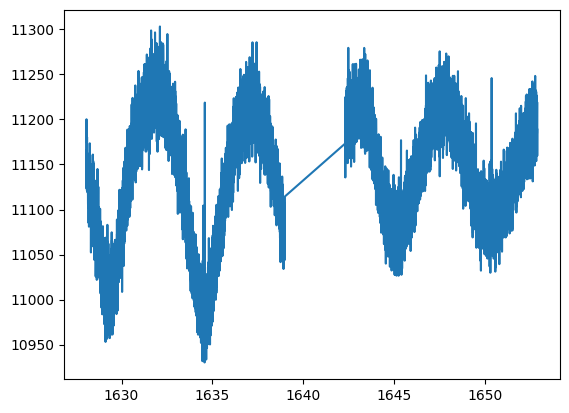

In [113]:
plt.plot(time, flux)

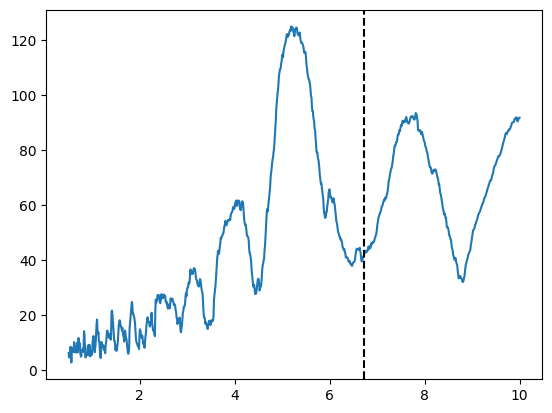

In [114]:
plt.plot(results.period, results.power)
plt.axvline(6.72, color='black', linestyle='--')

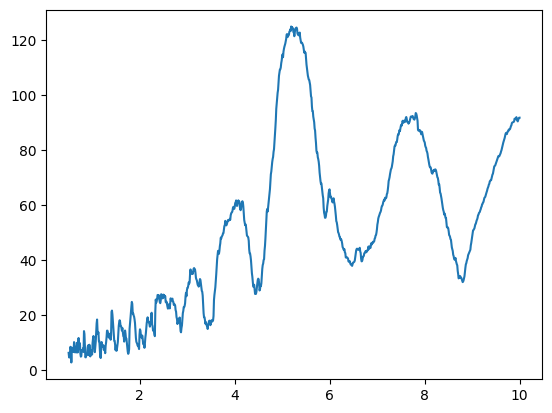

In [116]:
plt.plot(results.period, results.depth_snr)


In [120]:
max_power = np.argmax(results.power)
stats = model.compute_stats(results.period[max_power],
                            results.duration[max_power],
                            results.transit_time[max_power])

In [122]:
stats

{'transit_times': array([1629.45498647, 1634.64317466, 1639.83136285, 1645.01955104,
        1650.20773923]),
 'per_transit_count': array([69, 72,  0, 72, 72]),
 'per_transit_log_likelihood': array([2922.74173687, 4346.42974263,    0.        ,  595.71137877,
          79.72668109]),
 'depth': (101.51713648934674, 0.8131226987398122),
 'depth_phased': (-71.92695751060455, 0.7407104482663658),
 'depth_half': (5.770991608120312, 0.5534255182699351),
 'depth_odd': (113.03653242714245, 1.1365866039385186),
 'depth_even': (89.67008757748226, 1.1524824678131067),
 'harmonic_amplitude': 82.93977653569917,
 'harmonic_delta_log_likelihood': 130488.45526244337}

In [160]:
# need at least two tranits

In [ ]:
def do_bls(time, flux, flux_err):
    model = BoxLeastSquares(time, flux, flux_err)
    results = model.power(periods, 0.1)  # The second argument is the duration of the transit (in days)
    max_power = np.argmax(results.power)
    stats = model.compute_stats(results.period[max_power],
                                results.duration[max_power],
                                results.transit_time[max_power])
    return results, stats

In [ ]:
def do_inversion_test(time, flux, flux_error)
    inverted_flux = -1 * flux + 2* np.mean(flux))
    results, stats = do_bls(time, inverted_flux, flux_err)
    return results, stats

In [161]:
def find_planet(ticid):
    time, flux, flux_err  = np.load(f'lc_data/{ticid}.npy')

    time = time[~np.isnan(flux)]
    flux_err = flux_err[~np.isnan(flux)]
    flux = flux[~np.isnan(flux)]
    model = BoxLeastSquares(time, flux, flux_err)
    results = model.power(periods, 0.1)  # The second argument is the duration of the transit (in days)
    max_power = np.argmax(results.power)
    stats = model.compute_stats(results.period[max_power],
                                results.duration[max_power],
                                results.transit_time[max_power])

    
    # do the inversion test here? if we invert it and find the transit, not good.
    if len(stats['transit_times']) >= 2 and results.depth_snr[max_power] >= 10:

        # test for variability
        inverted_results, inverted_stats = do_inversion_test(time, flux, flux_error)
        if len(inverted_stats['transit_times']) < 2 or inverted_results.depth_snr[max_power] < 10:
            return True
            
    return False

        
        # we found a planet then!

# then: false positive rate
- explain what a false positive is.
- query Gaia to get a sense for false positive rate as a backup.
- tike angle: use dask!  

In [162]:
import dask

In [29]:
# find the TIC ID.

In [30]:
exofop_data = pd.read_csv('https://exofop.ipac.caltech.edu/tess/download_toi.php?sort=toi&output=csv')

In [31]:
# cross-match the TIC ID with that. 

In [ ]:
# need to 

In [8]:
Gaia.ROW_LIMIT = 50  # Ensure the default row limit.
coord = SkyCoord(ra=280, dec=-60, unit=(u.degree, u.degree), frame='icrs')
j = Gaia.cone_search_async(coord, radius=u.Quantity(1.0, u.deg))

INFO: Query finished. [astroquery.utils.tap.core]


In [ ]:
# when do we call it a detection?

In [137]:
293465600 in exofop_data['TIC ID'].values

False

In [150]:
catalog_data['ID'].value

masked_array(data=['257486953', '388583226', '432485132', ...,
                   '402105010', '117546088', '407996027'],
             mask=[False, False, False, ..., False, False, False],
       fill_value='N/A',
            dtype='<U10')

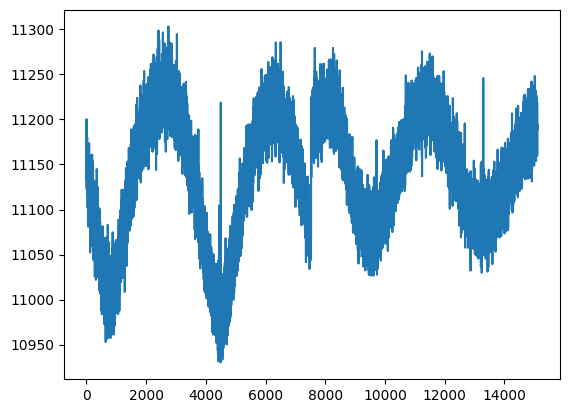

In [158]:
plt.plot(flux)

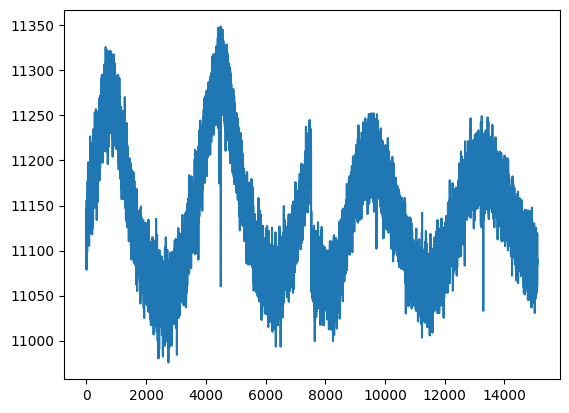

In [159]:
plt.plot(-1 * flux + 2* np.mean(flux))

In [140]:
'418981325' in catalog_data['ID'].value

False

In [141]:
149603524 in catalog

NameError: name 'catalog' is not defined

In [146]:
counter = 0
for i, row in exofop_data.iterrows():
    if str(row['TIC ID']) in catalog_data['ID'].value:
        counter +=1

In [148]:
counter/len(exofop_data)

0.06326304106548279

In [ ]:
# why are so few in there?

In [144]:
row['TIC ID']

284300833

In [43]:
exofop_data

,TIC ID,TOI,Previous CTOI,Master,SG1A,SG1B,SG2,SG3,SG4,SG5,...,Stellar Radius (R_Sun) err,Stellar Metallicity,Stellar Metallicity err,Stellar Mass (M_Sun),Stellar Mass (M_Sun) err,Sectors,Date TOI Alerted (UTC),Date TOI Updated (UTC),Date Modified,Comments
0,231663901,101.01,NaN,5,5,5,5,5,5,5,...,0.043847,NaN,NaN,1.050000,0.129454,"1,27",2018-09-05,2021-10-07,2022-12-14 12:09:24,WASP-46 b
1,149603524,102.01,NaN,5,5,5,5,5,5,5,...,0.050000,0.24,0.05,1.280000,0.190812,"1,2,3,4,6,7,8,9,10,11,12,13,27,28,29,30,31,32,...",2019-05-07,2023-11-16,2023-12-08 12:13:22,WASP 62 b
2,336732616,103.01,NaN,5,5,5,5,5,5,5,...,NaN,NaN,NaN,1.270000,0.196969,1,2018-09-05,2020-10-27,2022-12-14 12:09:24,HATS-3 b
3,231670397,104.01,NaN,5,5,5,5,5,5,5,...,0.102573,NaN,NaN,1.160000,0.166129,"1,27,67",2018-09-05,2023-10-16,2023-10-16 00:00:00,WASP-73 b
4,144065872,105.01,NaN,5,5,5,5,5,5,5,...,0.059699,NaN,NaN,1.030000,0.127209,"1,28",2018-09-05,2021-12-08,2022-12-14 12:09:24,WASP-95; epoch kept from qlp-s28-tois
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7203,22903436,7032.01,TIC 22903436.01,1,4,1,1,3,4,4,...,0.060000,NaN,NaN,0.710000,0.084607,"23,49,50,76,77",2024-07-25,2024-07-25,2024-08-16 12:14:51,variable host; matches period of CTOI from Pla...
7204,29953537,7033.01,TIC 29953537.01,1,4,1,1,1,4,4,...,0.050000,NaN,NaN,0.970000,0.127279,"8,9,35,36,62",2024-08-14,2024-08-14,2024-08-16 12:14:51,nearby bright variable star(TIC 29953651) whic...
7205,418981325,7034.01,NaN,3,4,3,3,1,4,4,...,NaN,NaN,NaN,NaN,NaN,"17,18,24,58,78",2024-08-14,2024-08-14,2024-08-16 12:14:51,period could be too short for host star
7206,366074071,7035.01,TIC 366074071.01,3,4,3,3,1,4,4,...,0.080000,NaN,NaN,1.242000,0.202573,"17,18,24,25,58,78",2024-08-14,2024-08-14,2024-08-16 12:14:51,This is the actual source of the signal origin...


In [90]:
# if it's not in thcatalog_data['ID']ere, we query Gaia.

In [91]:
catalog_data['ID'][40004]

'293465600'

In [103]:
ra = catalog_data[catalog_data['ID']=='293465600']['ra'].value[0]
ra

49.8430249133971

In [104]:
dec = catalog_data[catalog_data['ID']=='293465600']['dec'].value[0]
dec

-82.463077310715

In [ ]:
# what are he sc
catalog_data[catalog_data

In [105]:
Gaia.ROW_LIMIT = 50  # Ensure the default row limit.
coord = SkyCoord(ra=ra, dec=dec, unit=(u.degree, u.degree), frame='icrs')
j = Gaia.cone_search_async(coord, radius=u.Quantity(1.0, u.deg))

INFO: Query finished. [astroquery.utils.tap.core]


In [108]:
j.get_results()

solution_id,DESIGNATION,SOURCE_ID,random_index,ref_epoch,ra,ra_error,dec,dec_error,parallax,parallax_error,parallax_over_error,pm,pmra,pmra_error,pmdec,pmdec_error,ra_dec_corr,ra_parallax_corr,ra_pmra_corr,ra_pmdec_corr,dec_parallax_corr,dec_pmra_corr,dec_pmdec_corr,parallax_pmra_corr,parallax_pmdec_corr,pmra_pmdec_corr,astrometric_n_obs_al,astrometric_n_obs_ac,astrometric_n_good_obs_al,astrometric_n_bad_obs_al,astrometric_gof_al,astrometric_chi2_al,astrometric_excess_noise,astrometric_excess_noise_sig,astrometric_params_solved,astrometric_primary_flag,nu_eff_used_in_astrometry,pseudocolour,pseudocolour_error,ra_pseudocolour_corr,dec_pseudocolour_corr,parallax_pseudocolour_corr,pmra_pseudocolour_corr,pmdec_pseudocolour_corr,astrometric_matched_transits,visibility_periods_used,astrometric_sigma5d_max,matched_transits,new_matched_transits,matched_transits_removed,ipd_gof_harmonic_amplitude,ipd_gof_harmonic_phase,ipd_frac_multi_peak,ipd_frac_odd_win,ruwe,scan_direction_strength_k1,scan_direction_strength_k2,scan_direction_strength_k3,scan_direction_strength_k4,scan_direction_mean_k1,scan_direction_mean_k2,scan_direction_mean_k3,scan_direction_mean_k4,duplicated_source,phot_g_n_obs,phot_g_mean_flux,phot_g_mean_flux_error,phot_g_mean_flux_over_error,phot_g_mean_mag,phot_bp_n_obs,phot_bp_mean_flux,phot_bp_mean_flux_error,phot_bp_mean_flux_over_error,phot_bp_mean_mag,phot_rp_n_obs,phot_rp_mean_flux,phot_rp_mean_flux_error,phot_rp_mean_flux_over_error,phot_rp_mean_mag,phot_bp_rp_excess_factor,phot_bp_n_contaminated_transits,phot_bp_n_blended_transits,phot_rp_n_contaminated_transits,phot_rp_n_blended_transits,phot_proc_mode,bp_rp,bp_g,g_rp,radial_velocity,radial_velocity_error,rv_method_used,rv_nb_transits,rv_nb_deblended_transits,rv_visibility_periods_used,rv_expected_sig_to_noise,rv_renormalised_gof,rv_chisq_pvalue,rv_time_duration,rv_amplitude_robust,rv_template_teff,rv_template_logg,rv_template_fe_h,rv_atm_param_origin,vbroad,vbroad_error,vbroad_nb_transits,grvs_mag,grvs_mag_error,grvs_mag_nb_transits,rvs_spec_sig_to_noise,phot_variable_flag,l,b,ecl_lon,ecl_lat,in_qso_candidates,in_galaxy_candidates,non_single_star,has_xp_continuous,has_xp_sampled,has_rvs,has_epoch_photometry,has_epoch_rv,has_mcmc_gspphot,has_mcmc_msc,in_andromeda_survey,classprob_dsc_combmod_quasar,classprob_dsc_combmod_galaxy,classprob_dsc_combmod_star,teff_gspphot,teff_gspphot_lower,teff_gspphot_upper,logg_gspphot,logg_gspphot_lower,logg_gspphot_upper,mh_gspphot,mh_gspphot_lower,mh_gspphot_upper,distance_gspphot,distance_gspphot_lower,distance_gspphot_upper,azero_gspphot,azero_gspphot_lower,azero_gspphot_upper,ag_gspphot,ag_gspphot_lower,ag_gspphot_upper,ebpminrp_gspphot,ebpminrp_gspphot_lower,ebpminrp_gspphot_upper,libname_gspphot,dist
,,,,yr,deg,mas,deg,mas,mas,mas,,mas / yr,mas / yr,mas / yr,mas / yr,mas / yr,,,,,,,,,,,,,,,,,mas,,,,1 / um,1 / um,1 / um,,,,,,,,mas,,,,,deg,,,,,,,,deg,deg,deg,deg,,,electron / s,electron / s,,mag,,electron / s,electron / s,,mag,,electron / s,electron / s,,mag,,,,,,,mag,mag,mag,km / s,km / s,,,,,,,,d,km / s,K,log(cm.s**-2),dex,,km / s,km / s,,mag,mag,,,,deg,deg,deg,deg,,,,,,,,,,,,,,,K,K,K,log(cm.s**-2),log(cm.s**-2),log(cm.s**-2),dex,dex,dex,pc,pc,pc,mag,mag,mag,mag,mag,mag,mag,mag,mag,,
int64,object,int64,int64,float64,float64,float32,float64,float32,float64,float32,float32,float32,float64,float32,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int16,int16,int16,int16,float32,float32,float32,float32,int16,bool,float32,float32,float32,float32,float32,float32,float32,float32,int16,int16,float32,int16,int16,int16,float32,float32,int16,int16,float32,float32,float32,float32,float32,float32,float32,float32,float32,bool,int16,float64,float32,float32,float32,int16,float64,float32,float32,float32,int16,float64,float32,float32,float32,float32,int16,int16,int16,int16,int16,float32,float32,float32,float32,float32,int16,int16,int16,int16,float32,float32,float32,float32,float32,float32,float32,fl

# then: inject and recover?
- if this doesn't take too long, explain why injection and recovery matters — i.e., we want to know how sensitive we *would* be to a certain signal strength.
- inject transit signals with the batman package
- try to recover them with the simple pipeline that we wrote above. parallelize on multiple cores to make this faster. that's the TIKE angle.

In [124]:
batman

NameError: name 'batman' is not defined

# Then: account for completeness (transit probability)
- explain that not all planets transit. emphasize that this is simply a geometric effect, and we can account for it quickly and simply with a geometric factor.
- (if we want, we could derive this factor — it's maybe a 5 line derivation)
- tike angle: parallelize.

In [ ]:
a = np.power(G * Ms  * P**2 / (4 * np.pi**2), 1/3)
Ptr = 0.9 * (Rs + Rp)/a
# draw 100 (Rp, P) pairs.

# then: calculate occurrence rate!
- show an equation that demonstrates all the multiplicative factors and how they relate
- plot the histograms demonstrating the occurrence rate (with error bars!) of planets as a function of, e..g, orbital period
- demonstrate that this lines up or doesn't line up with the expectations from the literature
- if these are their own notebooks: the TIKE angle is

In [165]:
import os
os.cpu_count() 

4